In [1]:
import json
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

# ML
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Concatenate
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")
lemmatizer = WordNetLemmatizer()

# Paths
DATA_PATH = "intents.json"
OUT_DIR = Path("chatbot_model_output")
OUT_DIR.mkdir(exist_ok=True)


[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


In [3]:
# Load intents.json
with open(DATA_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

intents = data.get("intents", data)

texts, labels = [], []
responses_by_tag = {}

for intent in intents:
    tag = intent.get("tag")
    patterns = intent.get("patterns", [])
    responses = intent.get("responses", [])
    responses_by_tag[tag] = responses
    for p in patterns:
        texts.append(p)
        labels.append(tag)

print(f"Loaded {len(texts)} samples and {len(set(labels))} tags.")


Loaded 392 samples and 49 tags.


In [4]:
def preprocess_text(s):
    s = s.lower()
    tokens = word_tokenize(s)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalnum()]
    return " ".join(tokens)

texts = [preprocess_text(t) for t in texts]


In [5]:
VOCAB_SIZE = 6000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
MAX_LEN = min(40, max(len(seq) for seq in sequences))
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding="post")

top_n = 2000
def texts_to_multihot(texts):
    multihot = np.zeros((len(texts), top_n), dtype=np.float32)
    for i, txt in enumerate(texts):
        for w in txt.split():
            idx = tokenizer.word_index.get(w)
            if idx and idx <= top_n:
                multihot[i, idx-1] = 1.0
    return multihot

X_bow = texts_to_multihot(texts)


In [6]:
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)
y_onehot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Save preprocessing objects
pickle.dump(tokenizer, open(OUT_DIR/"tokenizer.pkl", "wb"))
pickle.dump(le, open(OUT_DIR/"label_encoder.pkl", "wb"))
pickle.dump(responses_by_tag, open(OUT_DIR/"responses_by_tag.pkl", "wb"))

# Train/test split
X_seq_train, X_seq_test, X_bow_train, X_bow_test, y_train, y_test = train_test_split(
    X_seq, X_bow, y_onehot, test_size=0.12, random_state=42
)


In [7]:
EMBED_DIM = 100
LSTM_UNITS = 128
MLP_UNITS = 128
DENSE_UNITS = 64
DROPOUT = 0.4

# Sequence branch
seq_input = Input(shape=(MAX_LEN,), name="seq_input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN)(seq_input)
x = LSTM(LSTM_UNITS)(x)
x = Dropout(DROPOUT)(x)

# BOW branch
bow_input = Input(shape=(top_n,), name="bow_input")
b = Dense(MLP_UNITS, activation="relu")(bow_input)
b = Dropout(DROPOUT)(b)

# Merge
concat = Concatenate()([x, b])
d = Dense(DENSE_UNITS, activation="relu")(concat)
d = Dropout(DROPOUT)(d)
output = Dense(num_classes, activation="softmax")(d)

model = Model(inputs=[seq_input, bow_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


c:\Users\B_Jayanth\OneDrive\Desktop\Medic AI Chatbot\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 11, 100)   │    600,000 │ seq_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bow_input           │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    256,128 │ bow_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 49)        │      3,185 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 993,009 (3.79 MB)

 Trainable params: 993,009 (3.79 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(
    {"seq_input": X_seq_train, "bow_input": X_bow_train},
    y_train,
    validation_data=({"seq_input": X_seq_test, "bow_input": X_bow_test}, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)


Epoch 1/50
22/22 - 6s - 277ms/step - accuracy: 0.0203 - loss: 3.8917 - val_accuracy: 0.0208 - val_loss: 3.8814
Epoch 2/50
22/22 - 0s - 15ms/step - accuracy: 0.0465 - loss: 3.8625 - val_accuracy: 0.0417 - val_loss: 3.8754
Epoch 3/50
22/22 - 0s - 15ms/step - accuracy: 0.0610 - loss: 3.8232 - val_accuracy: 0.0417 - val_loss: 3.8533
Epoch 4/50
22/22 - 0s - 15ms/step - accuracy: 0.0930 - loss: 3.7394 - val_accuracy: 0.0625 - val_loss: 3.7738
Epoch 5/50
22/22 - 0s - 14ms/step - accuracy: 0.1279 - loss: 3.6289 - val_accuracy: 0.0625 - val_loss: 3.7531
Epoch 6/50
22/22 - 0s - 14ms/step - accuracy: 0.1570 - loss: 3.4216 - val_accuracy: 0.0833 - val_loss: 3.6757
Epoch 7/50
22/22 - 0s - 13ms/step - accuracy: 0.2500 - loss: 3.1943 - val_accuracy: 0.1250 - val_loss: 3.5182
Epoch 8/50
22/22 - 0s - 13ms/step - accuracy: 0.2703 - loss: 2.9325 - val_accuracy: 0.1667 - val_loss: 3.3055
Epoch 9/50
22/22 - 0s - 12ms/step - accuracy: 0.3459 - loss: 2.6176 - val_accuracy: 0.2292 - val_loss: 3.0939
Epoch 10/

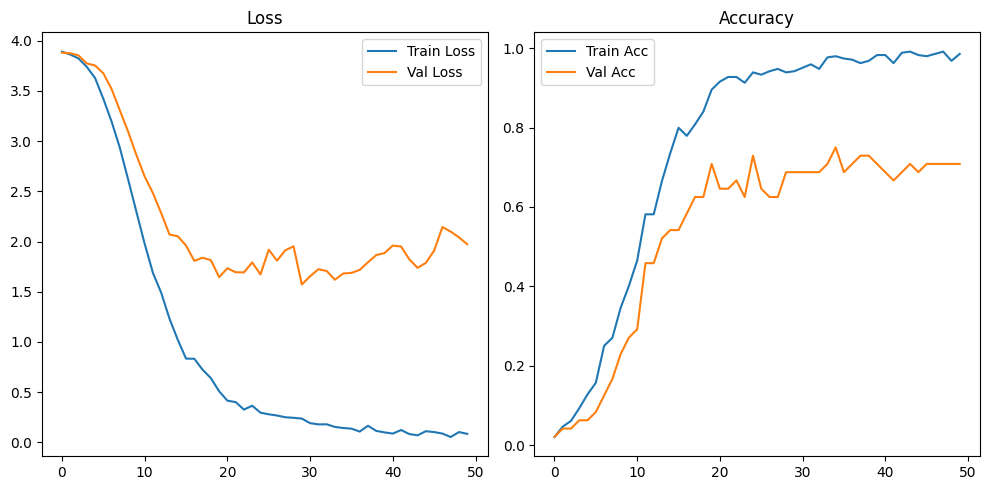

Final Train Acc: 0.9855
Final Val Acc: 0.7083
Final loss: 0.0845


In [9]:
# Save model
model.save(OUT_DIR/"medical_chatbot_model.h5")

# Plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.tight_layout()
plt.savefig(OUT_DIR/"training_history.png")
plt.show()

# Print final metrics
print(f"Final Train Acc: {history.history['accuracy'][-1]:.4f}")
print(f"Final Val Acc: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final loss: {history.history['loss'][-1]:.4f}")
